<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/exercise_trigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quests
- E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model? (COMPLETE!)
- E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see? (COMPLETE!)
- E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?(COMPLETE: If the smoothing part overweights the loss, the loss gets stuck.)
- E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W? (COMPLETE!)
- E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead? (COMPLETE; Reason to pick F.cross_entropy are two. First, more computational efficient. Second, that torch takes care of too large numbers that would result in INF, due to Floating points running out of space.)
- E06: meta-exercise! Think of a fun/interesting exercise and complete it.
Introduce Batching and find a good learning rate!(COMPLETE!)


In [233]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [234]:
words = open('names.txt', 'r').read().splitlines()

In [235]:
train_idx = int(len(words) * 0.8)
dev_idx = int(len(words) * 0.1)

train_words = words[:train_idx]
dev_words = words[train_idx:train_idx + dev_idx]
test_words = words[train_idx+dev_idx:]

print(f"Train set: {len(train_words)}")
print(f"Dev set: {len(dev_words)}")
print(f"Test set: {len(test_words)}")

Train set: 25626
Dev set: 3203
Test set: 3204


In [236]:
import torch

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

N = torch.zeros((27, 27, 27) , dtype=torch.int32)

for w in train_words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N[ix1, ix2, ix3] += 1

alpha = 1
N += alpha

In [237]:
P = N.float()
P /= P.sum(2, keepdim=True)

g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix1 = 0
  ix2 = 0
  while True:
    p = P[ix1, ix2]
    ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix3])
    if ix3 == 0:
      break
    ix1, ix2 = ix2, ix3
  print(''.join(out))

junide.
ilyasid.
prelayleinna.
jimritonia.
saree.


In [293]:
def calulate_loss(words):
  g = torch.Generator().manual_seed(2147483647)
  log_likelihood = 0.0
  n = 0

  for w in words:
  # for w in ["kanade"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
      ix1 = stoi[ch1]
      ix2 = stoi[ch2]
      ix3 = stoi[ch3]
      prob = P[ix1, ix2, ix3]
      logprob = torch.log(prob)
      log_likelihood += logprob
      n += 1
      # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

  print(f'{log_likelihood=}')
  nll = -log_likelihood
  print(f'{nll=}')
  print(f'{nll/n}')
  return "\n"

print(f"Train set {calulate_loss(train_words)}")
print(f"Dev set {calulate_loss(dev_words)}")
print(f"Test set {calulate_loss(test_words)}")

log_likelihood=tensor(-322671.4062)
nll=tensor(322671.4062)
2.053244113922119
Train set 

log_likelihood=tensor(-45202.6094)
nll=tensor(45202.6094)
2.3264338970184326
Dev set 

log_likelihood=tensor(-45653.1797)
nll=tensor(45653.1797)
2.337472677230835
Test set 



# NN with one layer

In [319]:
xs, ys = [], []

for w in train_words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    xs.append([ix1, ix2])
    ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [332]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)
C = torch.randn(27, 27, generator=g, requires_grad=True)

In [333]:
# to find a good lr
lre = torch.linspace(-1, 0.9, 1000)
lrs = 10**lre

In [321]:
lri = []
lossi = []
stepi = []

In [334]:
import torch.nn.functional as F

# gradient descent
for k in range(50000):

  # minibatch construct
  ix = torch.randint(0, xs.shape[0], (64,))

  # forward pass
  emb = C[xs[ix]]        # [N, 2, 27]
  xenc = emb.view((emb.shape[0]), -1)  # [N, 54]
  logits = xenc @ W


  loss = F.cross_entropy(logits, ys[ix])
  # print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  C.grad = None
  loss.backward()

  # update
  lr = 0.01 if k < 100000 else 0.5
  W.data += -lr* W.grad
  C.data += -lr* C.grad

  # track stats
  stepi.append(k)
  lossi.append(loss.item())
print(loss.item())

2.5055038928985596


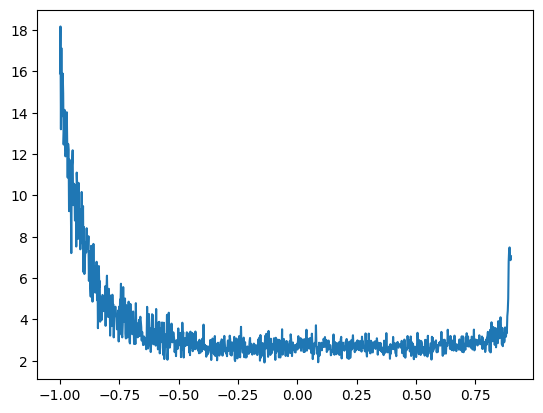

In [269]:
# Finding a good learning Rate!
import matplotlib.pyplot as plt
plt.plot(lri, lossi)


In [323]:
# Helper functions:
def calculate_loss(xs, ys):
  num = xs.shape[0]
  emb = C[xs]
  xenc = emb.view(num, -1)

  logits = xenc @ W
  loss = F.cross_entropy(logits, ys)

  return loss

def one_hot_encode(words):
  xs, ys = [], []

  for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
      ix1 = stoi[ch1]
      ix2 = stoi[ch2]
      ix3 = stoi[ch3]

      xs.append([ix1, ix2])
      ys.append(ix3)

  xs = torch.tensor(xs)
  ys = torch.tensor(ys)

  return xs, ys

In [335]:
# Dev loss
xs, ys = one_hot_encode(dev_words)
dev_loss = calculate_loss(xs, ys)
print(f"Dev loss: {dev_loss}")

Dev loss: 2.3547487258911133


In [336]:
# Test loss
xs, ys = one_hot_encode(test_words)
test_loss = calculate_loss(xs, ys)
print(f"Dev loss: {test_loss}")

Dev loss: 2.3217933177948


In [337]:
# sample
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
  out = []
  ix1 = 0
  ix2 = 0
  while True:
      x = torch.tensor([[ix1, ix2]])
      emb = C[x]                      # shape [1, 2, 27]
      xenc = emb.view(1, -1)          # shape [1, 54]

      logits = xenc @ W               # shape [1, 27]
      p = F.softmax(logits, dim=1)

      ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itos[ix3])
      if ix3 == 0:
        break
      ix1, ix2 = ix2, ix3
  print(''.join(out))

juwjded.
onakah.
san.
kyon.
kai.
shin.
toleon.
juez.
ksianiauwanilevias.
jedainrwir.
